<a href="https://colab.research.google.com/github/ori112/social-ads-bayesian-methods/blob/main/social_ads_bayesian_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian methods
exploring some bayesian methods to asses what features imapct users to purchase products once they were displayed with social ads

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pymc as pm
import arviz as az
from sklearn.calibration import calibration_curve

In [ ]:
# reading the file
df = pd.read_csv(r'/content/Social_Network_Ads.csv')

In [ ]:
# inspecting datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


<Axes: xlabel='Gender', ylabel='count'>

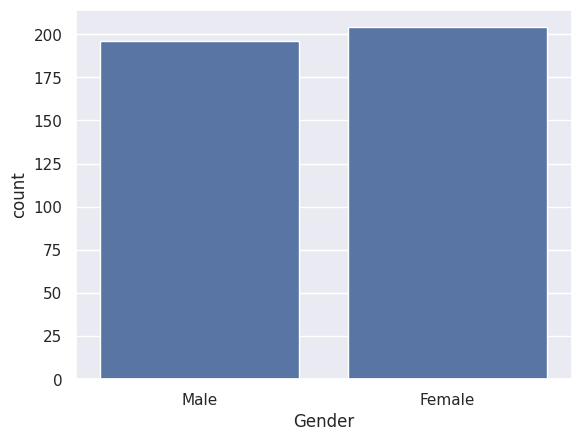

In [ ]:
# checking if Gender is imbalanced
sns.countplot(data=df, x="Gender")

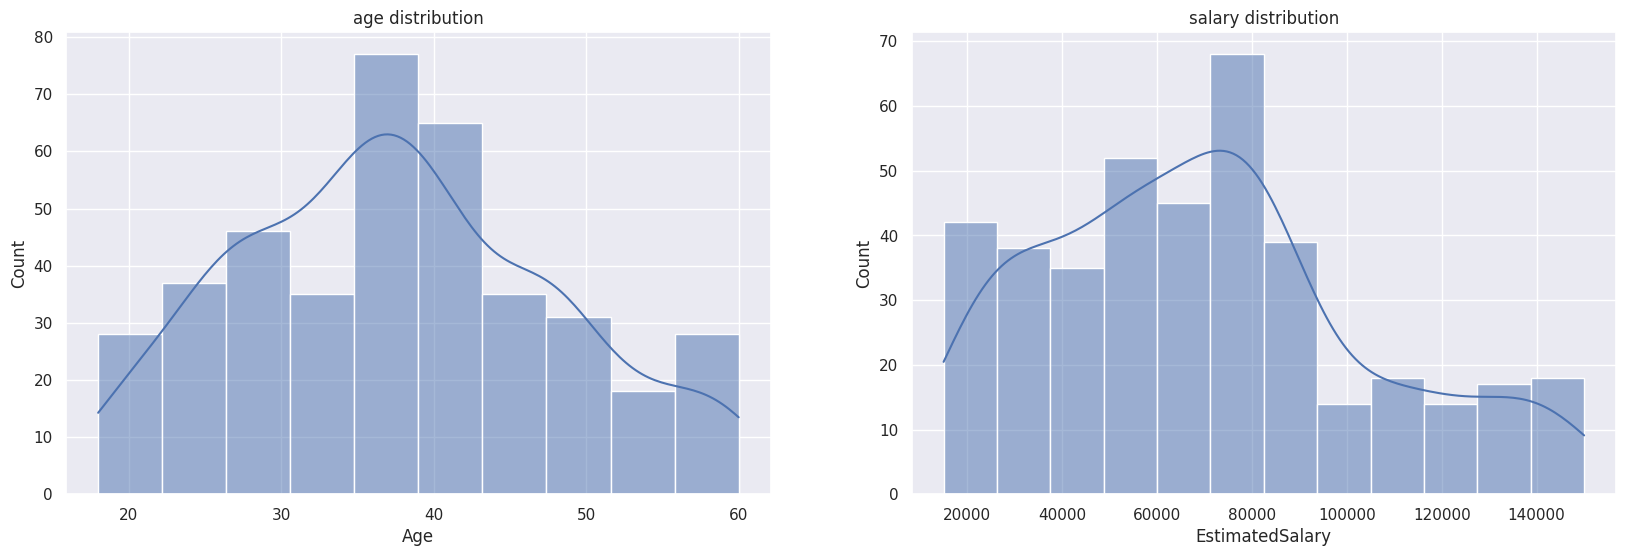

In [ ]:
# checking distributions
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.histplot(x=df["Age"], kde=True)
plt.title("age distribution")

plt.subplot(1,2,2)
sns.histplot(x=df["EstimatedSalary"], kde=True)
plt.title("salary distribution")

plt.show()

<Figure size 1200x800 with 0 Axes>

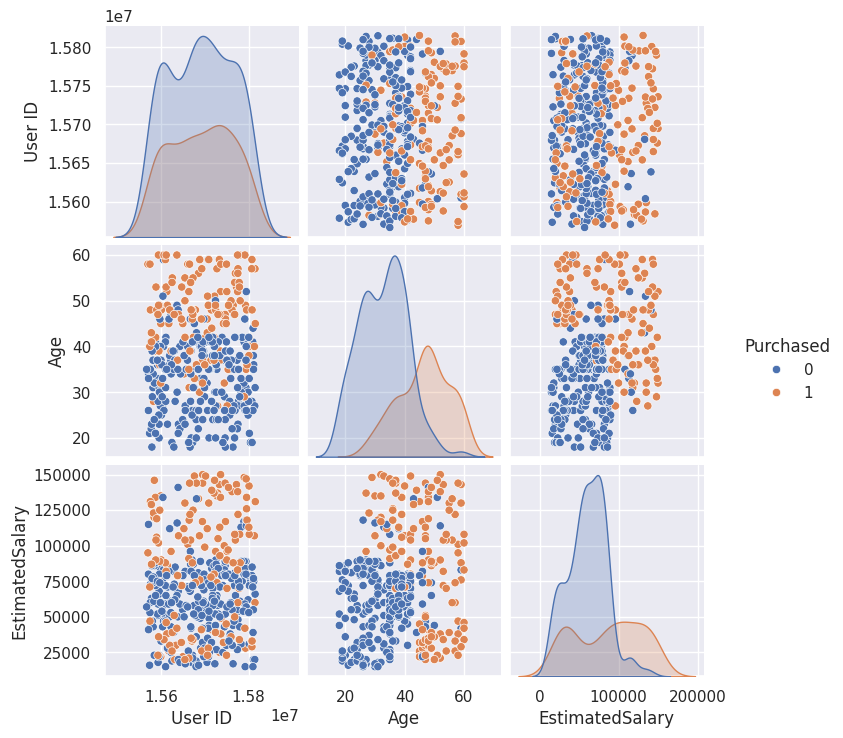

In [ ]:
# inspecting relationships between features
plt.figure(figsize=(12,8))
sns.pairplot(data=df, hue="Purchased")
plt.show()

In [ ]:
# encoding Gender
df = pd.get_dummies(df, "Gender").astype(int)

# renaming columns
df = df.rename(columns={"Gender_Male":"Male", "Gender_Female":"Female"})

In [ ]:
df.head()

,User ID,Age,EstimatedSalary,Purchased,Female,Male
0,15624510,19,19000,0,0,1
1,15810944,35,20000,0,0,1
2,15668575,26,43000,0,1,0
3,15603246,27,57000,0,1,0
4,15804002,19,76000,0,0,1


## model assumptions
estimated salary and age were normalized to avoid divergencies in model
normal distribution with a sigma 10 was estimated for all predictors for uncertainty

the results of the formula passed in a sigmoid function to create probabilties that range between 0-1

In [ ]:
# Extract predictors and target
age = df["Age"].values
age = (df["Age"] - df["Age"].mean()) / df["Age"].std()
salary = df["EstimatedSalary"].values
salary = (df["EstimatedSalary"] - df["EstimatedSalary"].mean()) / df["EstimatedSalary"].std()
gender = df["Male"].values  # Use one gender column (Male = 1, Female = 0)
purchased = df["Purchased"].values



with pm.Model() as logistic_model:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_age = pm.Normal("beta_age", mu=0, sigma=10)
    beta_salary = pm.Normal("beta_salary", mu=0, sigma=10)
    beta_gender = pm.Normal("beta_gender", mu=0, sigma=10)

    logit_p = beta_0 + beta_age * age + beta_salary * salary + beta_gender * gender
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))  # Save p as a deterministic variable

    likelihood = pm.Bernoulli("likelihood", p=p, observed=purchased)

    trace = pm.sample(tune=3000, draws=2000, chains=4, target_accept=0.99, random_seed=42)

Output()

Output()

Output()

Output()

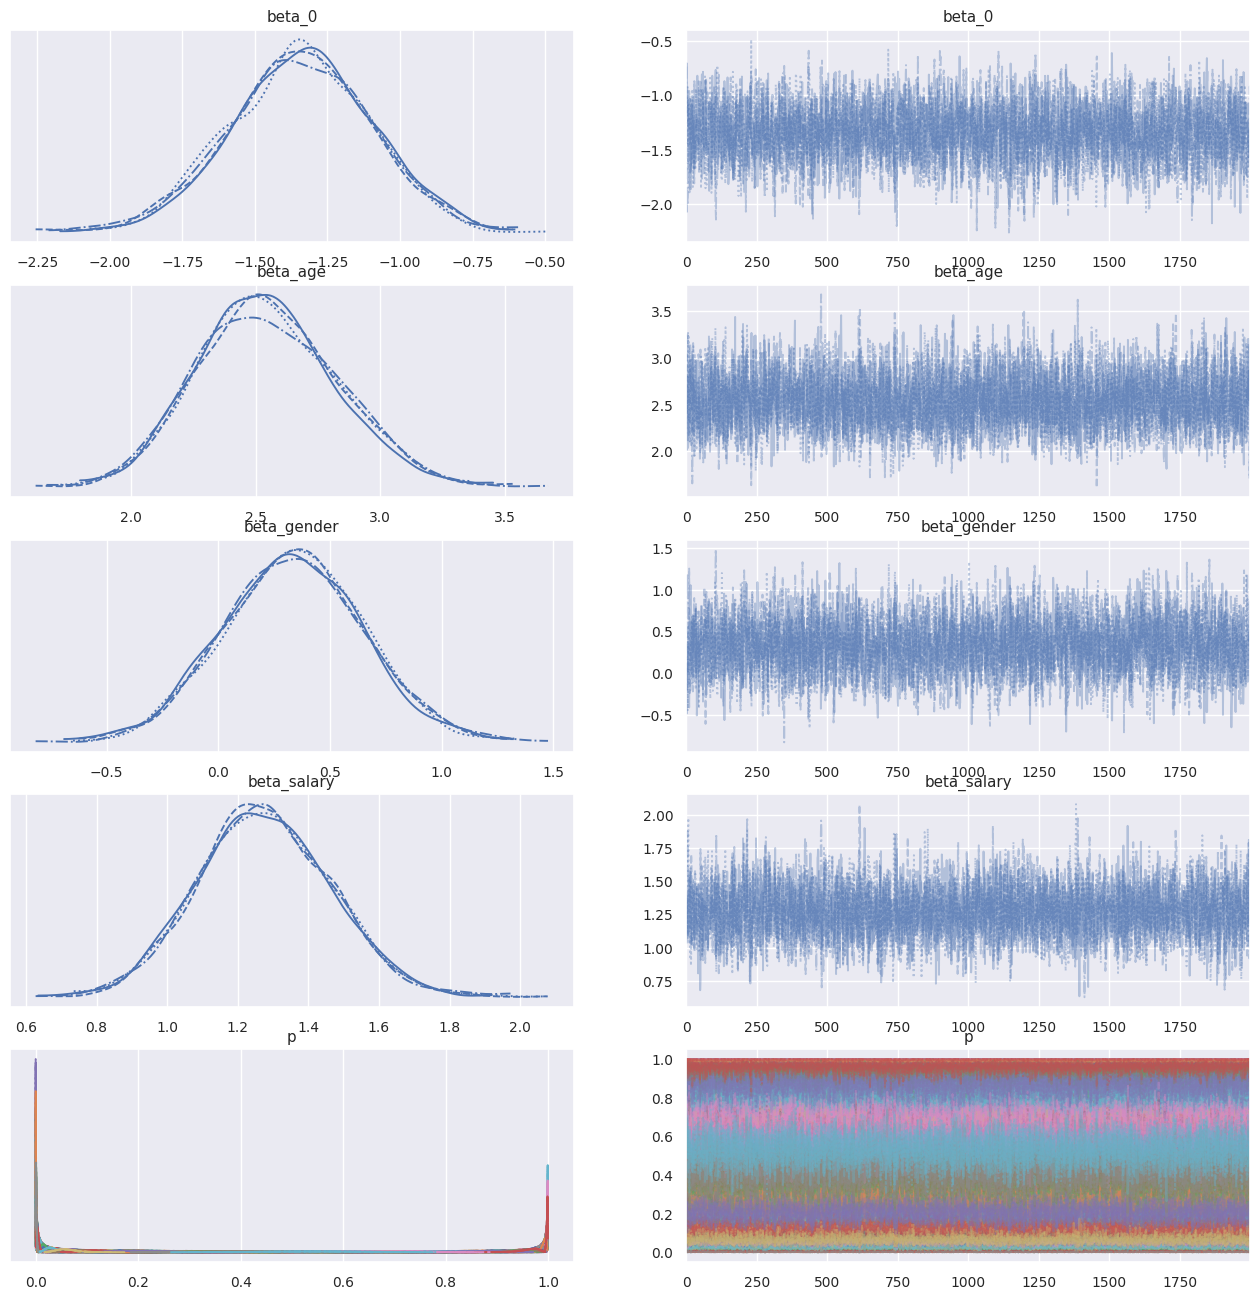

In [ ]:
az.plot_trace(trace, figsize=(16,16))
plt.show()

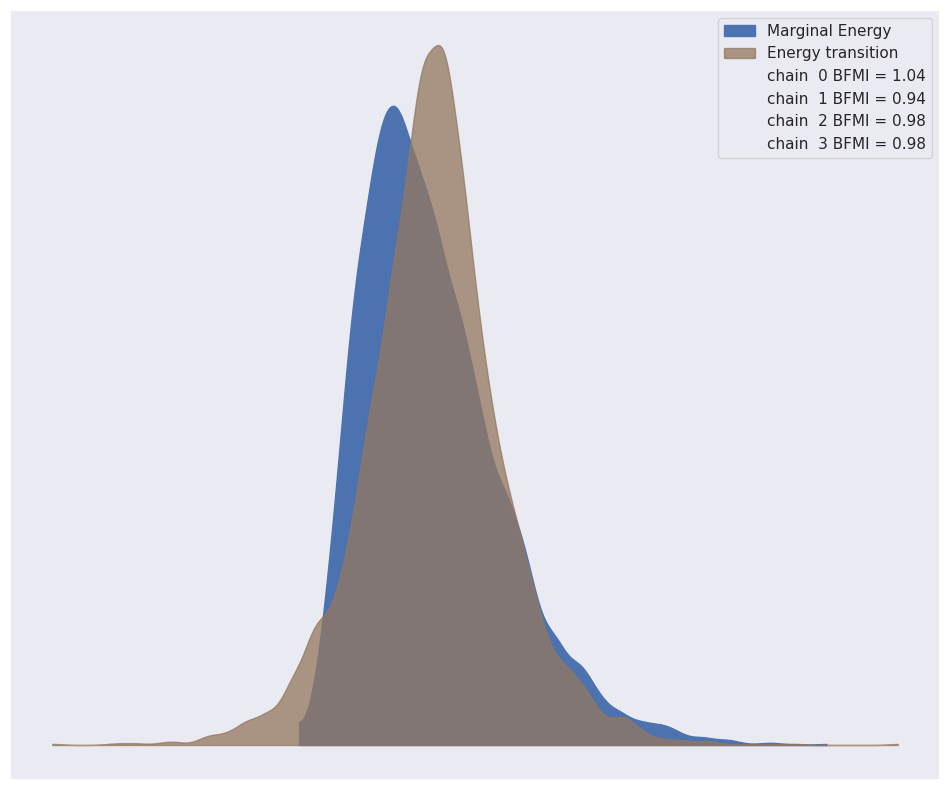

In [ ]:
az.plot_energy(trace, figsize=(12,10))
plt.show()

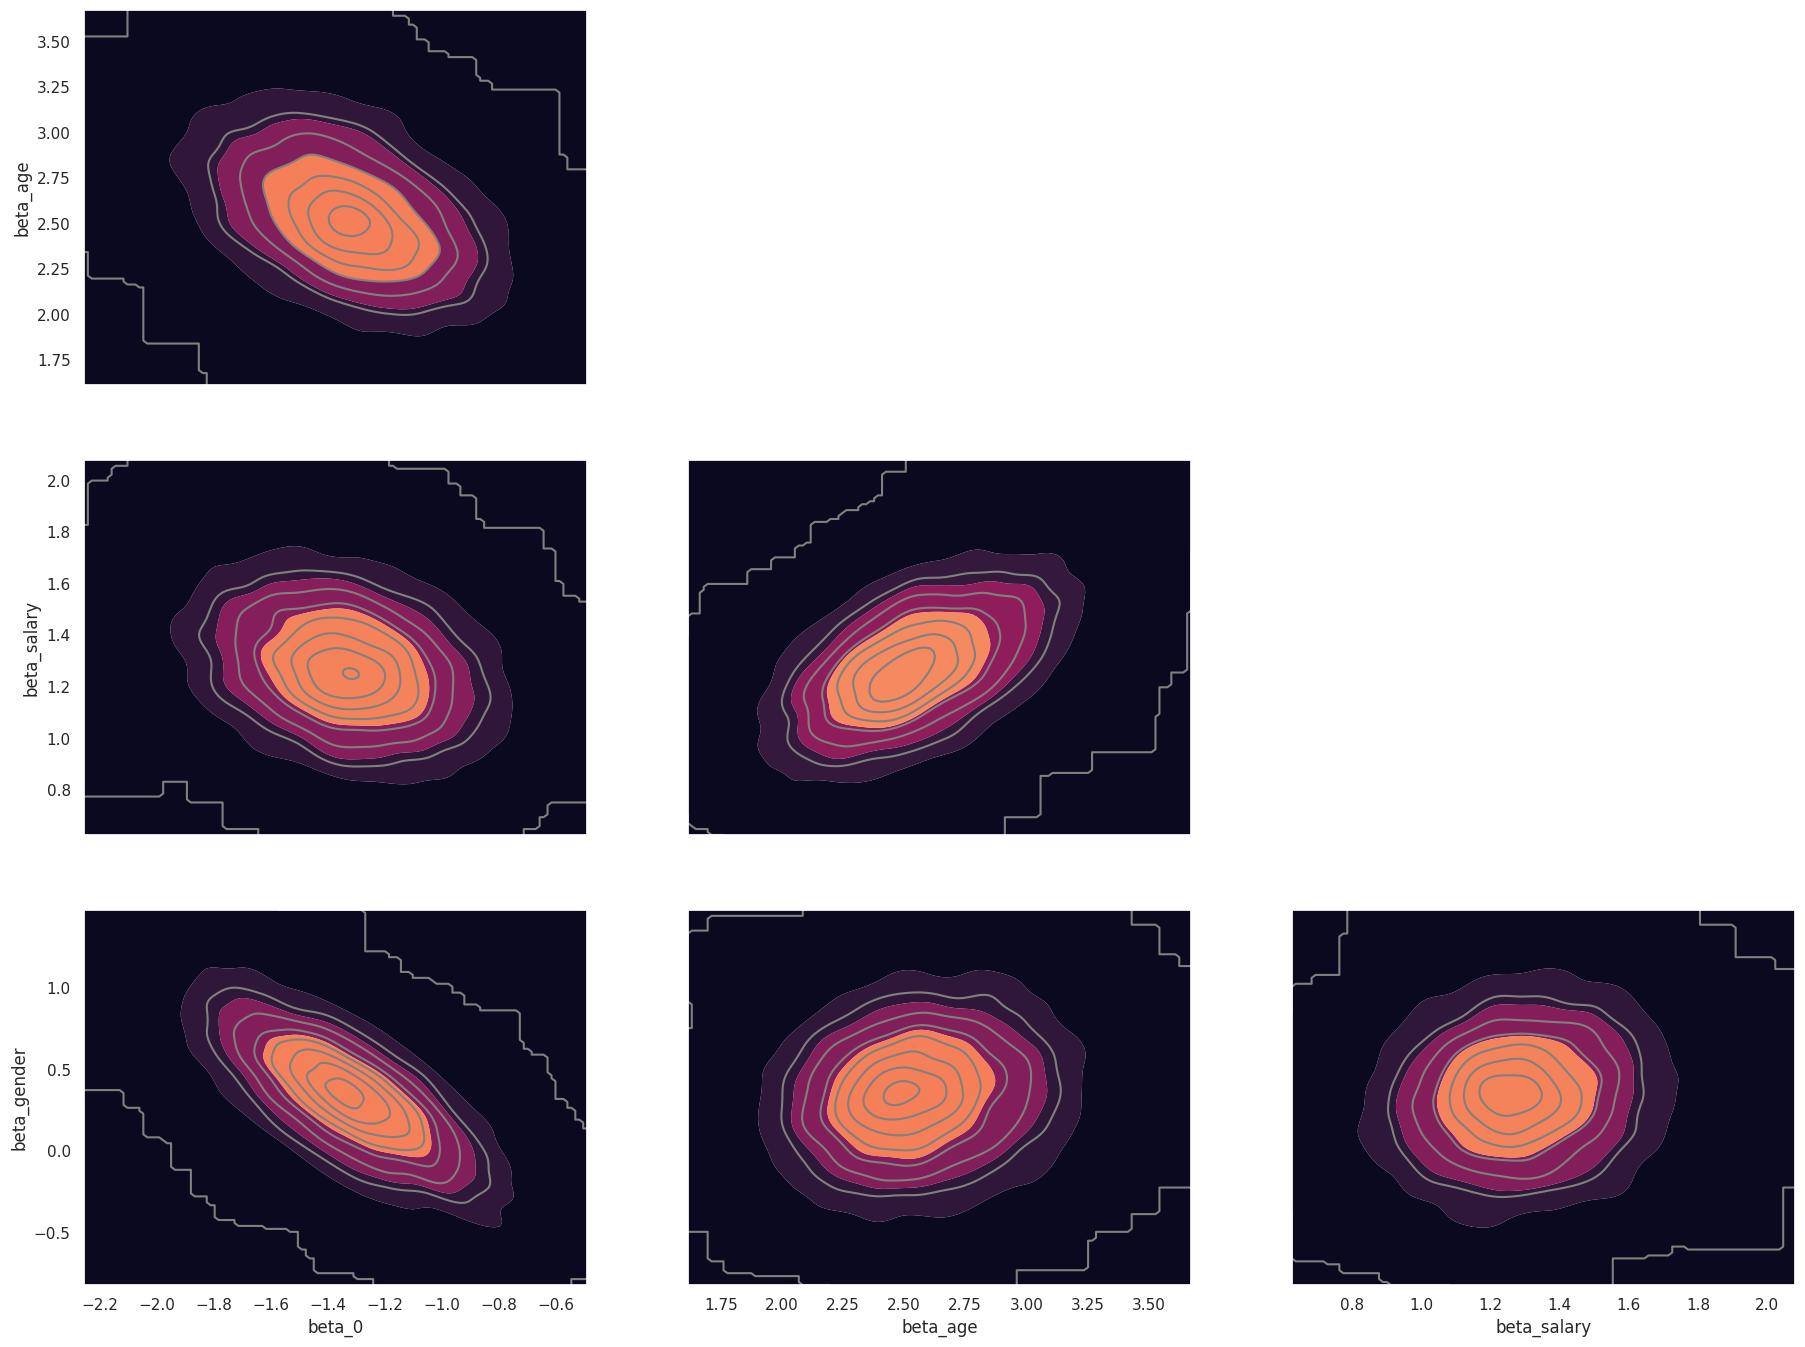

In [ ]:
az.plot_pair(
    trace,
    var_names=["beta_0", "beta_age", "beta_salary", "beta_gender"],
    kind="kde"
)
plt.show()

Output()

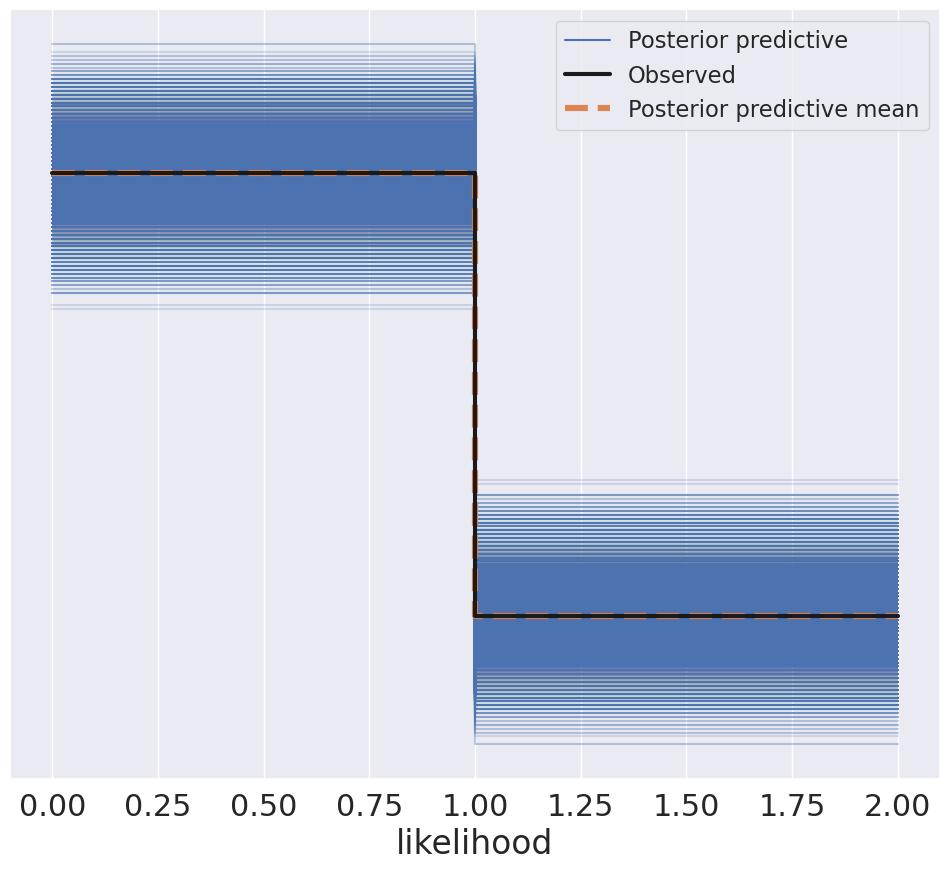

In [ ]:
with logistic_model:
    ppc = pm.sample_posterior_predictive(trace)

az.plot_ppc(ppc, figsize=(12,10))
plt.show()

Age seems to be a positive contributer to the likelyhood the users will purchase, the intercept starts with a negative impact

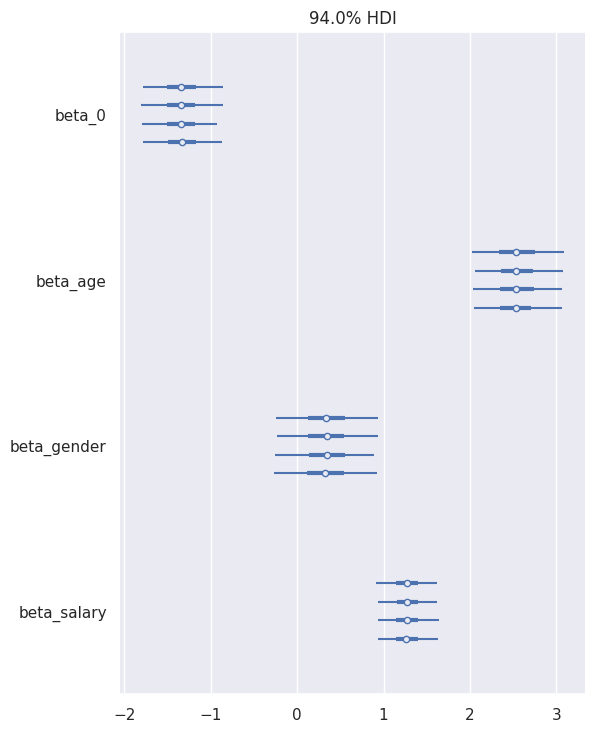

In [ ]:
az.plot_forest(trace, var_names=["beta_0", "beta_age", "beta_gender", "beta_salary"])
plt.show()

there are some errors, more errors for the FN type of error, in general there is a good seperation

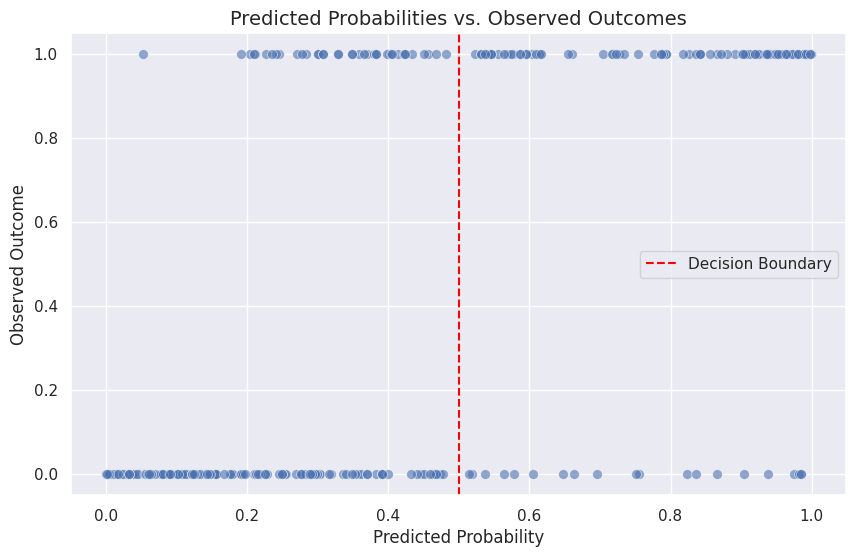

In [ ]:
# Extract the predicted probabilities
predicted_probs = trace.posterior["p"].mean(dim=("chain", "draw")).values

# Create a scatter plot for observed outcomes vs. predicted probabilities
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predicted_probs, y=purchased, alpha=0.6, s=50)
plt.axvline(0.5, color="red", linestyle="--", label="Decision Boundary")
plt.title("Predicted Probabilities vs. Observed Outcomes", fontsize=14)
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Outcome")
plt.legend()
plt.show()

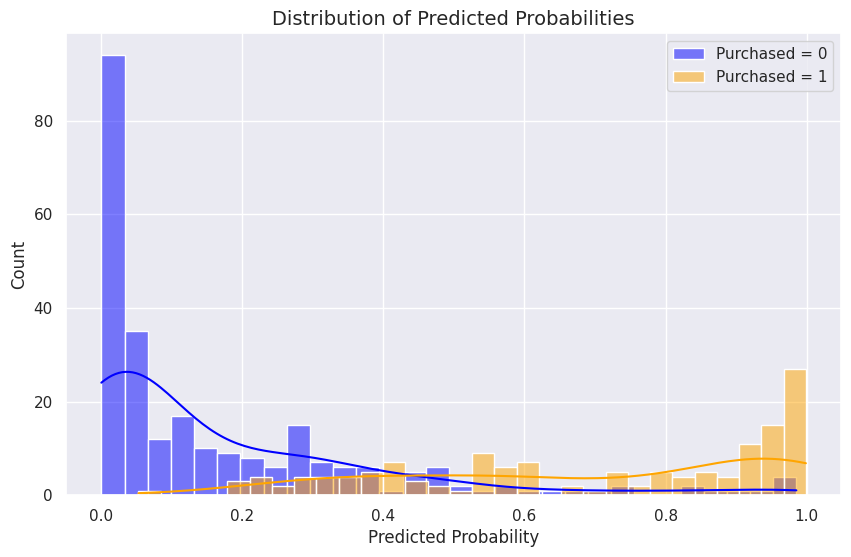

In [ ]:
# Create a histogram of predicted probabilities by observed outcome
plt.figure(figsize=(10, 6))
sns.histplot(predicted_probs[purchased == 0], color="blue", label="Purchased = 0", kde=True, bins=30)
sns.histplot(predicted_probs[purchased == 1], color="orange", label="Purchased = 1", kde=True, bins=30)
plt.title("Distribution of Predicted Probabilities", fontsize=14)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


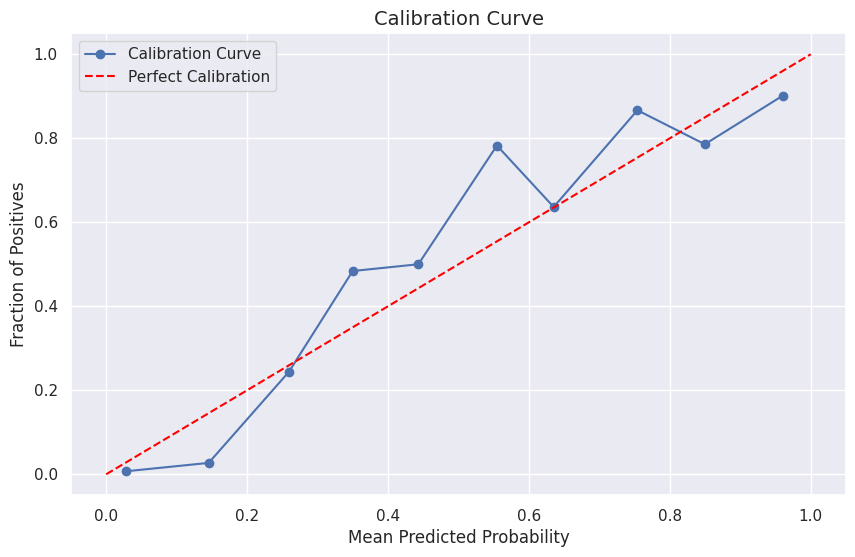

In [ ]:
prob_true, prob_pred = calibration_curve(purchased, predicted_probs, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Calibration Curve")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Perfect Calibration")
plt.title("Calibration Curve", fontsize=14)
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()


### inspecting marginal importance
for Age - the critical zone where the predicted probabilty rises is around -0.5-1 (scaled)
for Estimated salary - a linear relationship is present

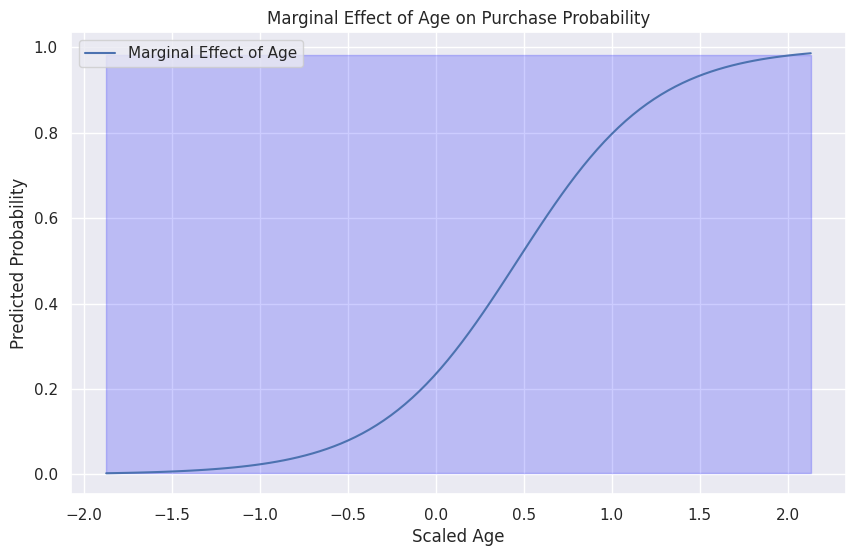

In [ ]:
# Marginal effects for Age
age_range = np.linspace(age.min(), age.max(), 100)
salary_mean = np.mean(salary)
gender_mean = np.mean(gender)

# Simulate new data with varying Age, holding other variables constant
simulated_data = {
    "Age": age_range,
    "EstimatedSalary": np.full_like(age_range, salary_mean),
    "Gender": np.full_like(age_range, gender_mean),
}

# Compute predicted probabilities
predicted_probs = []
for age_val in simulated_data["Age"]:
    logit_p_val = (
        trace.posterior["beta_0"].mean().item()
        + trace.posterior["beta_age"].mean().item() * age_val
        + trace.posterior["beta_salary"].mean().item() * salary_mean
        + trace.posterior["beta_gender"].mean().item() * gender_mean
    )
    predicted_probs.append(pm.math.sigmoid(logit_p_val).eval())

# Convert predicted_probs to a NumPy array
predicted_probs = np.array(predicted_probs)

# Plot the marginal effect of Age
plt.figure(figsize=(10, 6))
plt.plot(age_range, predicted_probs, label="Marginal Effect of Age")
plt.xlabel("Scaled Age")
plt.ylabel("Predicted Probability")
plt.title("Marginal Effect of Age on Purchase Probability")
lower_bound = np.percentile(predicted_probs, 2.5, axis=0)
upper_bound = np.percentile(predicted_probs, 97.5, axis=0)
plt.fill_between(age_range, lower_bound, upper_bound, color="blue", alpha=0.2)
plt.legend()
plt.show()


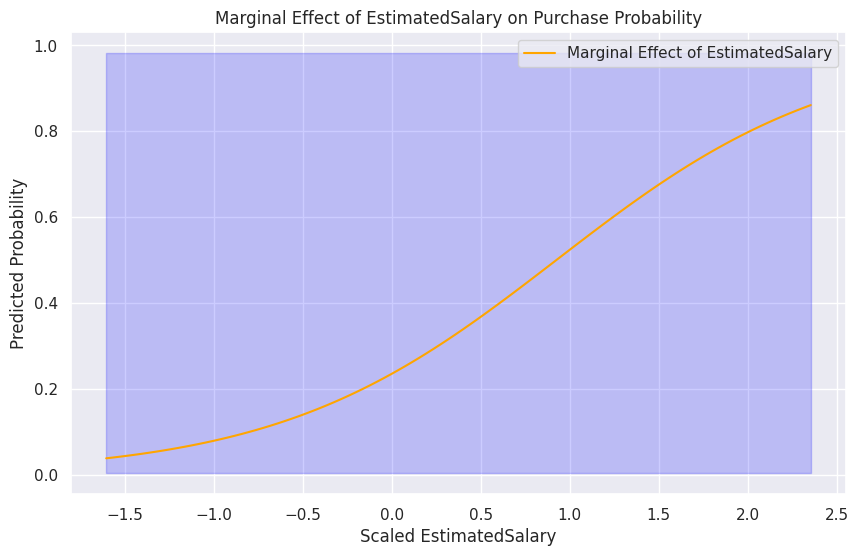

In [ ]:
# Marginal effects for EstimatedSalary
salary_range = np.linspace(salary.min(), salary.max(), 100)
age_mean = np.mean(age)
gender_mean = np.mean(gender)

# Compute predicted probabilities for different values of EstimatedSalary
predicted_probs_salary = []
for salary_val in salary_range:
    logit_p_val = (
        trace.posterior["beta_0"].mean().item()
        + trace.posterior["beta_age"].mean().item() * age_mean
        + trace.posterior["beta_salary"].mean().item() * salary_val
        + trace.posterior["beta_gender"].mean().item() * gender_mean
    )
    predicted_probs_salary.append(pm.math.sigmoid(logit_p_val).eval())

# Convert to NumPy array
predicted_probs_salary = np.array(predicted_probs_salary)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(salary_range, predicted_probs_salary, label="Marginal Effect of EstimatedSalary", color="orange")
plt.xlabel("Scaled EstimatedSalary")
plt.ylabel("Predicted Probability")
plt.title("Marginal Effect of EstimatedSalary on Purchase Probability")
lower_bound = np.percentile(predicted_probs, 2.5, axis=0)
upper_bound = np.percentile(predicted_probs, 97.5, axis=0)
plt.fill_between(salary_range, lower_bound, upper_bound, color="blue", alpha=0.2)
plt.legend()
plt.show()


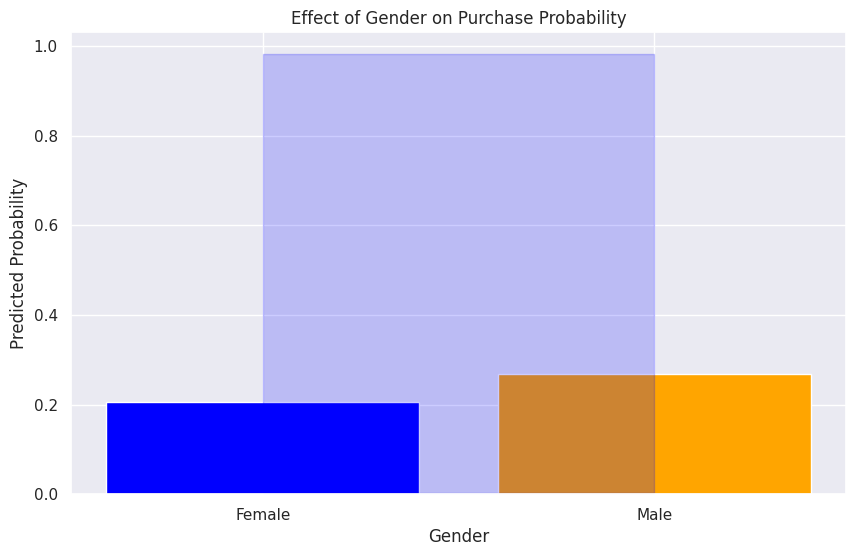

In [ ]:
# Marginal effects for Gender
gender_values = [0, 1]  # Female = 0, Male = 1
age_mean = np.mean(age)
salary_mean = np.mean(salary)

# Compute predicted probabilities for Gender
predicted_probs_gender = []
for gender_val in gender_values:
    logit_p_val = (
        trace.posterior["beta_0"].mean().item()
        + trace.posterior["beta_age"].mean().item() * age_mean
        + trace.posterior["beta_salary"].mean().item() * salary_mean
        + trace.posterior["beta_gender"].mean().item() * gender_val
    )
    predicted_probs_gender.append(pm.math.sigmoid(logit_p_val).eval())

# Plot
plt.figure(figsize=(10, 6))
plt.bar(["Female", "Male"], predicted_probs_gender, color=["blue", "orange"])
plt.xlabel("Gender")
plt.ylabel("Predicted Probability")
plt.title("Effect of Gender on Purchase Probability")
lower_bound = np.percentile(predicted_probs, 2.5, axis=0)
upper_bound = np.percentile(predicted_probs, 97.5, axis=0)
plt.fill_between(gender_values, lower_bound, upper_bound, color="blue", alpha=0.2)
plt.show()
